# Изучение зависимости функции потерь от вариации устанавливаемой бинарной маски

Наличие зависимости говорит о возможности оптимизации в ходе повышения дискретизации в процессе обучения.


In [1]:
# pip install keras scikit-learn plotly
# rev 1
import numpy as np
import itertools
import plotly.graph_objects as go
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.cluster import KMeans


# Load MNIST data


(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()



# Preprocess the data



x_train = x_train.astype("float32") / 255.0


x_test = x_test.astype("float32") / 255.0


x_train = np.expand_dims(x_train, -1)


x_test = np.expand_dims(x_test, -1)


y_train = keras.utils.to_categorical(y_train, 10)


y_test = keras.utils.to_categorical(y_test, 10)



# Define the model architecture


def create_model():

    model = keras.Sequential(
        [

            keras.Input(shape=(28, 28, 1)),

            layers.Conv2D(8, (3, 3), activation="relu"),  # Smaller filter count for simplicity
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(10, activation="softmax"),
        ]
    )


    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


    return model


# Train and evaluate the model with specific filter masks
def train_and_evaluate(model, mask):
    weights = model.layers[0].get_weights()
    weights[0] = weights[0] * mask
    model.layers[0].set_weights(weights)
    model.fit(x_train, y_train, epochs=5, batch_size=32, verbose=0)
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    return test_loss, test_acc


# Generate all binary combinations for the filters (excluding the first filter)
num_filters = 8
initial_filter_index = 0
all_combinations = itertools.product([0, 1], repeat=num_filters - 1)
results = []

base_model = create_model()
base_model.fit(x_train, y_train, epochs=5, verbose=0)
k = 0
for combo in all_combinations:
    k += 1
    if k > 5:
        continue
    mask = np.ones((3, 3, 1, num_filters))
    mask[:, :, :, initial_filter_index] = 1
    for i, active in enumerate(combo, start=initial_filter_index + 1):
        mask[:, :, :, i] = active
    loss, acc = train_and_evaluate(base_model, mask)
    results.append((combo, loss, acc))
    print(k, loss, acc)

# Calculate average accuracy
average_acc = np.mean([acc for _, _, acc in results])

# Filter results for those above average accuracy
filtered_results = [result for result in results if result[2] > average_acc]

# Create a 3D scatter plot of the filtered results
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=[hash(combo) % 512 for combo, _, _ in filtered_results],  # Projecting binary combo to x
            y=[hash(combo) // 512 for combo, _, _ in filtered_results],  # Projecting binary combo to y
            z=[loss for _, loss, _ in filtered_results],
            mode="markers",
            marker=dict(size=5, color=[acc for _, _, acc in filtered_results], colorscale="Viridis", opacity=0.8),  # Color by accuracy, filtered
        )
    ]
)
fig.update_layout(title="3D Scatter Plot of CNN Patterns (Above Average Accuracy)", scene=dict(xaxis_title="Pattern Hash X", yaxis_title="Pattern Hash Y", zaxis_title="Loss"))
fig.show()

1 0.12453458458185196 0.9621000289916992
2 0.12256196141242981 0.9634000062942505
3 0.11397507041692734 0.965499997138977
4 0.11656732112169266 0.963100016117096
5 0.11394278705120087 0.9653000235557556


In [25]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

# Load and preprocess data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.expand_dims(x_train / 255.0, axis=-1)
x_test = np.expand_dims(x_test / 255.0, axis=-1)
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)


# Define a function to create the CNN model
def create_model(custom_filter):
    model = Sequential()
    # Ensure the custom filter shape is [3, 3, 1, 1] for (kernel_height, kernel_width, input_channels, output_channels)
    model.add(Conv2D(1, (3, 3), activation="relu", input_shape=(28, 28, 1), kernel_initializer=tf.keras.initializers.Constant(custom_filter), bias_initializer="zeros"))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(10, activation="softmax"))
    model.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"])
    return model


# Generate 512 unique 3x3 binary filters with the correct shape
filters = np.random.randint(0, 2, (512, 3, 3, 1, 1))[:5]  # Notice the shape here

results = []

for i in range(len(filters)):
    # Create a new model with the current filter
    model = create_model(filters[i])
    # Train the model (you may choose to reduce the number of epochs or data size for speed)
    model.fit(x_train, y_train, epochs=1, batch_size=64, verbose=0)
    # Evaluate the model
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    results.append((filters[i], loss, accuracy))
    print(f"Filter {i+1}/512 - Loss: {loss}, Accuracy: {accuracy}")

# Optionally, you can save or further analyze the `results` list

c:\git\MUIV\video_pocessing\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Filter 1/512 - Loss: 0.3535514771938324, Accuracy: 0.8988999724388123
Filter 2/512 - Loss: 0.33531180024147034, Accuracy: 0.9017000198364258
Filter 3/512 - Loss: 0.33954089879989624, Accuracy: 0.899399995803833
Filter 4/512 - Loss: 0.33023521304130554, Accuracy: 0.906000018119812
Filter 5/512 - Loss: 0.33625560998916626, Accuracy: 0.9017999768257141


In [171]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import plotly.graph_objects as go

# Load and preprocess MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.expand_dims(x_train / 255.0, axis=-1)
x_test = np.expand_dims(x_test / 255.0, axis=-1)
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)


# Define the CNN model creation function
def create_model(custom_filter):
    model = Sequential(
        [
            Conv2D(1, (3, 3), activation="relu", input_shape=(28, 28, 1), kernel_initializer=tf.keras.initializers.Constant(custom_filter), bias_initializer="zeros"),
            MaxPooling2D((2, 2)),
            Flatten(),
            Dense(10, activation="softmax"),
        ]
    )
    model.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"])
    return model


# Generate 512 unique 3x3 binary filters
filters = np.random.randint(0, 2, (512, 3, 3, 1, 1))

results = []

# Test each filter configuration
counter = 0
for i in range(len(filters)):
    counter += 1
    print(counter)
    model = create_model(filters[i])
    model.fit(x_train, y_train, epochs=1, batch_size=64, verbose=0)
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    results.append((filters[i], loss, accuracy))

# Compute the average accuracy
average_accuracy = np.median([acc for _, _, acc in results])

# Filter results for above-average accuracy
filtered_results = [res for res in results if res[2] > average_accuracy]

# Plotly 3D scatter plot
fig = go.Figure()

# Add each filter as a point in the 3D scatter plot
for idx, (filter, loss, acc) in enumerate(filtered_results):
    for i in range(3):
        for j in range(3):
            if filter[i, j][0, 0] == 1:
                fig.add_trace(
                    go.Scatter3d(
                        x=[i],
                        y=[j],
                        z=[idx],
                        mode="markers",
                        marker=dict(size=2, color=[acc], colorscale="Viridis", opacity=0.8),  # z-position is the index of the filter in the list
                    )
                )

fig.update_layout(
    title="3D Scatter Plot of Filters with Above Average Accuracy",
    scene=dict(
        xaxis_title="Row in Filter",
        yaxis_title="Column in Filter",
        zaxis_title="Filter Index",
        xaxis=dict(nticks=4, range=[-0.5, 2.5]),
        yaxis=dict(nticks=4, range=[-0.5, 2.5]),
        zaxis=dict(nticks=10),
    ),
)
fig.show()

1


c:\git\MUIV\video_pocessing\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

In [90]:
len([res for res in results if res[2] > average_accuracy])

29

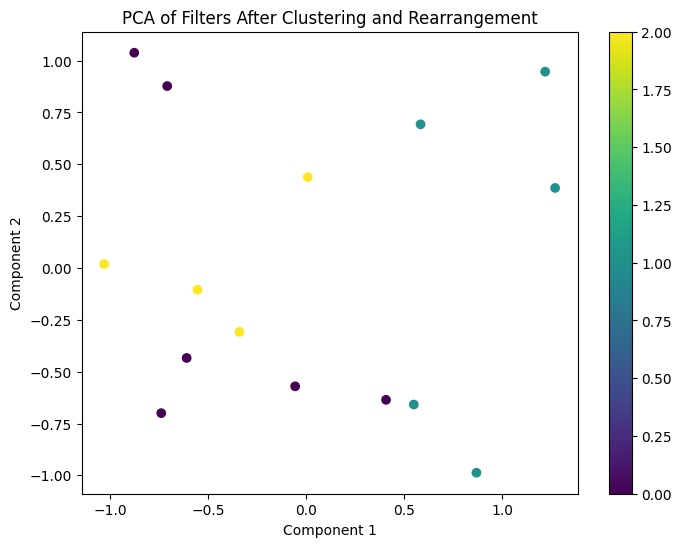

In [149]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA  # For visualization
import matplotlib.pyplot as plt


def rearrange_filters_by_clustering(filters, max_clusters=3):
    # Perform KMeans clustering
    n_clusters = min(max_clusters, len(np.unique(filters, axis=0)))  # Adjust cluster number based on unique filters
    if n_clusters < 2:
        print("Not enough unique filters for multiple clusters.")
        return filters  # Not enough unique elements to form clusters

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(filters)

    # Calculate distances to cluster centers for sorting within clusters
    centers = kmeans.cluster_centers_
    distances = np.linalg.norm(filters - centers[cluster_labels, :], axis=1)  # Correcting index and calculation

    # Sorting by cluster label, then by distance within each cluster
    sorted_indices = np.lexsort((distances, cluster_labels))  # Sort indices by distances then by labels
    sorted_filters = filters[sorted_indices]

    return sorted_filters


# Assume some example data for flat_filters
flat_filters = np.random.randint(0, 2, (15, 9))

# Rearrange filters
rearranged_filters = rearrange_filters_by_clustering(flat_filters)

# Visualization with PCA to show clusters
pca = PCA(n_components=2)
projected = pca.fit_transform(rearranged_filters)
plt.figure(figsize=(8, 6))
plt.scatter(projected[:, 0], projected[:, 1], c=KMeans(n_clusters=3, random_state=42).fit_predict(rearranged_filters), cmap="viridis")
plt.colorbar()
plt.title("PCA of Filters After Clustering and Rearrangement")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

In [172]:
import numpy as np
import plotly.graph_objects as go

# Assuming rearranged_filters is available from previous steps
# Here's a dummy example similar to what might be output from the previous steps
# Just for demonstration; replace this with your actual 'rearranged_filters' array
rearranged_filters = np.random.randint(0, 2, (15, 9))

# Reshape filters back to 3x3 matrices
reshaped_filters = rearranged_filters.reshape(-1, 3, 3)

# Create a 3D scatter plot using Plotly
fig = go.Figure()

# Offset to separate the filters in the plot visually
offset = 5

for i, filter_matrix in enumerate(reshaped_filters):
    # Compute x, y, z coordinates for each element in the 3x3 filter matrix
    # Adding 'i * offset' to z-coordinate to spread out each filter in the z-direction
    x, y = np.meshgrid(range(3), range(3))
    x = x.flatten()
    y = y.flatten()
    z = np.full_like(x, i * offset)  # Create a flat z array at the current offset

    # Filter only points where the filter value is 1
    indices = filter_matrix.flatten() == 1
    x = x[indices]
    y = y[indices]
    z = z[indices]

    # Adding each filter's data to the plot
    fig.add_trace(
        go.Scatter3d(
            x=x,
            y=y,
            z=z,
            mode="markers",
            marker=dict(
                size=8,
                color="blue",  # Static color for 1s
            ),
            name=f"Filter {i+1}",
        )
    )

# Update plot layout
fig.update_layout(
    title="3D Scatter Plot of Active Elements in Reshaped Filters",
    scene=dict(xaxis_title="X Axis (Matrix Columns)", yaxis_title="Y Axis (Matrix Rows)", zaxis_title="Z Axis (Filter Index)"),
    legend_title="Filter Index",
)

# Show the plot
fig.show()

In [125]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def calculate_silhouette(filters, n_clusters=3):
    """Calculate the silhouette score for the given set of filters with specified number of clusters."""
    if len(filters) < n_clusters or len(np.unique(filters, axis=0)) < n_clusters:
        return -1  # Not enough unique samples to form the required number of clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(filters)
    score = silhouette_score(filters, cluster_labels)
    return score

# Assuming 'filtered_results' contains tuples of (filter, loss, accuracy) where filter is a 3x3x1x1 array
flat_filters = np.array([res[0].reshape(-1) for res in filtered_results])  # Flatten each filter for clustering

# Filter results for above-average accuracy
average_accuracy = np.mean([res[2] for res in filtered_results])
filtered_results = [res for res in filtered_results if res[2] > average_accuracy]

if len(filtered_results) < 3:
    print("Not enough filters with above-average accuracy to perform clustering.")
else:
    # Forward Selection to find the best combination of filters
    best_combination = []
    current_score = -1
    remaining_filters = list(range(len(filtered_results)))

    while remaining_filters:
        best_new_score = current_score
        best_new_filter = None
        for i in remaining_filters:
            test_combination = [flat_filters[j] for j in best_combination + [i]]
            if len(np.unique(test_combination, axis=0)) < 3:
                continue  # Ensure there are at least 3 unique filters
            test_score = calculate_silhouette(np.array(test_combination), n_clusters=3)
            if test_score > best_new_score:
                best_new_score = test_score
                best_new_filter = i

        if best_new_filter is None:
            break  # No improvement found, stop the process
        best_combination.append(best_new_filter)
        remaining_filters.remove(best_new_filter)
        current_score = best_new_score
        print(f"Added filter index {best_new_filter}, New Silhouette Score: {current_score}")

    # Final report
    print(f"Best Combination Silhouette Score: {current_score}")
    print(f"Number of filters in the best combination: {len(best_combination)}")
[:2]

SyntaxError: invalid syntax (1156969381.py, line 51)

In [47]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import plotly.graph_objects as go

# Sample data generation


# Convert each decimal combo to a 3x3 binary matrix
def decimal_to_binary_matrix(decimal, size=9):
    binary_string = format(decimal, "0{}b".format(size))
    binary_array = np.array(list(map(int, binary_string)))
    return binary_array.reshape(3, 3)


matrices = np.array([decimal_to_binary_matrix(result[0]) for result in results])
accuracies = np.array([result[1] for result in results])

# Flatten each 3x3 matrix for clustering
flat_matrices = matrices.reshape(len(matrices), -1)

# Cluster the entire dataset
n_clusters = 5  # Example cluster count
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(flat_matrices)

# Calculate silhouette score
silhouette_avg = silhouette_score(flat_matrices, clusters)

# Visualization
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=flat_matrices[:, 0],  # Example dimension
            y=flat_matrices[:, 1],  # Example dimension
            z=flat_matrices[:, 2],  # Example dimension
            mode="markers",
            marker=dict(size=5, color=clusters, colorscale="Viridis", opacity=0.8),
        )
    ]
)
fig.update_layout(
    title=f"3D Scatter Plot of Clustered Configurations, Silhouette Score: {silhouette_avg}", scene=dict(xaxis_title="Feature 1", yaxis_title="Feature 2", zaxis_title="Feature 3")
)
fig.show()

TypeError: unsupported format string passed to numpy.ndarray.__format__

In [8]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import plotly.graph_objects as go

# Sample data generation
np.random.seed(42)
# Assuming 'results' is a list of tuples (combo, acc), where combo is a decimal representation
results = [((np.random.randint(0, 512)), np.random.rand()) for _ in range(256)]


# Convert each decimal combo to a 3x3 binary matrix
def decimal_to_binary_matrix(decimal, size=9):
    binary_string = format(decimal, "0{}b".format(size))
    binary_array = np.array(list(map(int, binary_string)))
    return binary_array.reshape(3, 3)


matrices = [decimal_to_binary_matrix(result[0]) for result in results]
accuracies = [result[1] for result in results]

# Evaluate clustering for each matrix and find the best one
best_score = -1
best_index = -1
for i, matrix in enumerate(matrices):
    flat_matrix = matrix.reshape(1, -1)  # Flatten the matrix for clustering
    kmeans = KMeans(n_clusters=2, random_state=42)  # Adjust the number of clusters as needed
    kmeans.fit(flat_matrix)
    score = silhouette_score(flat_matrix, kmeans.labels_)
    if score > best_score:
        best_score = score
        best_index = i

# Prepare to visualize the best matrix
best_matrix = matrices[best_index]
best_acc = accuracies[best_index]

# Prepare 3D scatter plot
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=[i % 3 for i in range(9)],
            y=[i // 3 for i in range(9)],
            z=[best_index for _ in range(9)],
            mode="markers",
            marker=dict(size=5, color=best_matrix.flatten(), colorscale="Viridis", opacity=0.8),
        )
    ]
)
fig.update_layout(
    title=f"3D Scatter Plot of Best Clustered 3x3 Configuration with Silhouette Score {best_score}",
    scene=dict(xaxis_title="X Coordinate", yaxis_title="Y Coordinate", zaxis_title="Combo Index"),
)
fig.show()

ValueError: n_samples=1 should be >= n_clusters=2.

In [9]:
results

[(102, 0.7965429868602328),
 (270, 0.7319939418114051),
 (188, 0.596850157946487),
 (121, 0.15599452033620265),
 (330, 0.45924889196586716),
 (372, 0.6011150117432088),
 (151, 0.6508884729488529),
 (308, 0.9699098521619943),
 (491, 0.9385527090157502),
 (385, 0.18182496720710062),
 (276, 0.6174815096277165),
 (313, 0.5247564316322378),
 (235, 0.023062425041415757),
 (474, 0.6118528947223795),
 (169, 0.04666566321361543),
 (187, 0.3663618432936917),
 (189, 0.0906064345328208),
 (445, 0.19967378215835974),
 (54, 0.9832308858067882),
 (504, 0.046450412719997725),
 (306, 0.6803075385877797),
 (328, 0.06505159298527952),
 (387, 0.9422017556848528),
 (13, 0.8083973481164611),
 (264, 0.015966252220214194),
 (385, 0.6842330265121569),
 (366, 0.6832635188254582),
 (427, 0.4951769101112702),
 (430, 0.17336465350777208),
 (80, 0.2587799816000169),
 (359, 0.7553614103176525),
 (509, 0.5200680211778108),
 (105, 0.5677003278199915),
 (476, 0.9695846277645586),
 (217, 0.44975413336976566),
 (201, 0.8

In [ ]:
import numpy as np
import itertools
import plotly.graph_objects as go
from multiprocessing import Pool
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import backend as K


# Define a function to create a model
def create_model():
    model = Sequential(
        [
            Conv2D(8, (3, 3), activation="relu", input_shape=(28, 28, 1)),
            MaxPooling2D((2, 2)),
            Flatten(),
            Dense(10, activation="softmax"),
        ]
    )
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model


# Function to train and evaluate the model
def train_and_evaluate(args):
    combo, mask = args
    K.clear_session()  # Clear session to avoid clutter from old models/layers
    model = create_model()
    weights = model.layers[0].get_weights()
    weights[0] = weights[0] * mask
    model.layers[0].set_weights(weights)
    model.fit(x_train, y_train, epochs=5, batch_size=32, verbose=0)
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    return combo, test_loss, test_acc


# Load and preprocess data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.expand_dims(x_train / 255.0, -1)
x_test = np.expand_dims(x_test / 255.0, -1)
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Generate all binary combinations for the filters (excluding the first filter)
num_filters = 8
initial_filter_index = 0
all_combinations = list(itertools.product([0, 1], repeat=num_filters - 1))
tasks = []

for combo in all_combinations:
    mask = np.ones((3, 3, 1, num_filters))
    mask[:, :, :, initial_filter_index] = 1
    for i, active in enumerate(combo, start=initial_filter_index + 1):
        mask[:, :, :, i] = active
    tasks.append((combo, mask))

# Use multiprocessing to run the tasks in parallel
if __name__ == "__main__":
    with Pool(processes=4) as pool:  # Adjust number of processes based on your CPU
        results = pool.map(train_and_evaluate, tasks)

    # Continue with plotting or analysis as before...
    # Calculate average accuracy
    average_acc = np.mean([acc for _, _, acc in results])

    # Filter results for those above average accuracy
    filtered_results = [result for result in results if result[2] > average_acc]

    # Create a 3D scatter plot of the filtered results
    fig = go.Figure(
        data=[
            go.Scatter3d(
                x=[hash(combo) % 512 for combo, _, _ in filtered_results],  # Projecting binary combo to x
                y=[hash(combo) // 512 for combo, _, _ in filtered_results],  # Projecting binary combo to y
                z=[loss for _, loss, _ in filtered_results],
                mode="markers",
                marker=dict(size=5, color=[acc for _, _, acc in filtered_results], colorscale="Viridis", opacity=0.8),  # Color by accuracy, filtered
            )
        ]
    )
    fig.update_layout(title="3D Scatter Plot of CNN Patterns (Above Average Accuracy)", scene=dict(xaxis_title="Pattern Hash X", yaxis_title="Pattern Hash Y", zaxis_title="Loss"))

In [3]:
# Train and evaluate the model with specific filter masks
def train_and_evaluate(model, mask):
    weights = model.layers[0].get_weights()
    weights[0] = weights[0] * mask
    model.layers[0].set_weights(weights)
    model.fit(x_train, y_train, epochs=5, batch_size=32, verbose=0)
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    return test_loss, test_acc


# Generate all binary combinations for the filters (excluding the first filter)
num_filters = 8
initial_filter_index = 0
all_combinations = itertools.product([0, 1], repeat=num_filters - 1)
results = []

base_model = create_model()
base_model.fit(x_train, y_train, epochs=5, verbose=0)
i = 0
for combo in all_combinations:
    i += 1
    print(i)
    mask = np.ones((3, 3, 1, num_filters))
    mask[:, :, :, initial_filter_index] = 1
    for i, active in enumerate(combo, start=initial_filter_index + 1):
        mask[:, :, :, i] = active
    loss, acc = train_and_evaluate(base_model, mask)
    results.append((combo, loss, acc))

# Create a 3D scatter plot of the results
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=[hash(combo) % 512 for combo, _, _ in results],  # Projecting binary combo to x
            y=[hash(combo) // 512 for combo, _, _ in results],  # Projecting binary combo to y
            z=[loss for _, loss, _ in results],
            mode="markers",
            marker=dict(size=5, color=[acc for _, _, acc in results], colorscale="Viridis", opacity=0.8),  # Color by accuracy
        )
    ]
)
fig.update_layout(title="3D Scatter Plot of CNN Patterns", scene=dict(xaxis_title="Pattern Hash X", yaxis_title="Pattern Hash Y", zaxis_title="Loss"))
fig.show()

KeyboardInterrupt: 